<a href="https://colab.research.google.com/github/sailalitha96/Lung-Nodule-Detection/blob/master/Datapreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
import SimpleITK as sitk
from PIL import Image
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None


from PIL import Image
from scipy.misc import imread
from joblib import Parallel, delayed
import tflearn as tf
from tflearn.data_utils import build_hdf5_image_dataset
from scipy.ndimage import rotate, imread
import h5py
%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None
from keras.layers import Input, merge
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop
from keras.utils import  to_categorical
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
# print(matplotlib.__file__)
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *

In [0]:
#### Importing annotations and candidates csv files ####
annotations = pd.read_csv('D:/data/annotations.csv')
candidates = pd.read_csv('D:/data/candidates.csv')

In [0]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
seriesuid    551065 non-null object
coordX       551065 non-null float64
coordY       551065 non-null float64
coordZ       551065 non-null float64
class        551065 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [0]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
seriesuid      1186 non-null object
coordX         1186 non-null float64
coordY         1186 non-null float64
coordZ         1186 non-null float64
diameter_mm    1186 non-null float64
dtypes: float64(4), object(1)
memory usage: 46.4+ KB


In [0]:
# ##################### Samples are heavily imbalanced #####################

# print(len(candidates[candidates['class'] == 0]))
# print(len(candidates[candidates['class'] == 1]))
# print ('percentage of positive cases are ' + str(len(candidates[candidates['class'] == 1])*100.0/len(candidates))+" %")

549714
1351
percentage of positive cases are 0.24516164154863765 %


In [0]:
# positives = candidates[candidates['class']==1].index  
# negatives = candidates[candidates['class']==0].index

# ########################## Under sample negative class data ############################

# np.random.seed(42)
# neg_chosen_index = np.random.choice(negatives, len(positives)*4, replace = False)

# candidates_df = candidates.iloc[list(positives)+list(neg_chosen_index)]

In [0]:
# #################### train_test_split into test and training sets #####################

# from sklearn.model_selection import train_test_split
# X = candidates_df.iloc[:,:-1]
# y = candidates_df.iloc[:,-1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [0]:
# #################################### Splitting training data further for validation set ##################################
# X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [0]:
# ############################ Getting the proportions of positive cases in the training data ##############################

# print ('number of positive cases are ' + str(y_train.sum()))
# print ('total set size is ' + str(len(y_train)))
# print ('percentage of positive cases are ' + str(y_train.sum()*100.0/len(y_train))+" %")

number of positive cases are 866
total set size is 4323
percentage of positive cases are 20.0323849178811 %


In [0]:
# ############################ Using pickle for data storage ############################
# X_train.to_pickle('train_data')
# X_test.to_pickle('test_data')
# X_eval.to_pickle('eval_data')
# y_train.to_pickle('train_labels')
# y_test.to_pickle('test_labels')
# y_eval.to_pickle('eval_labels')

In [0]:
class ct_scan_processing(object):
    """
    Class that manipulates and processes over images in the dataset using SimpleITK tools and PIL library.
    Is responsible for:
    1. Read the image from specified filename
    2. Convert the image into it's array representation,
    3. Get coordinates corresponding to origin, voxel,
    4. Reset the coordinates of the original image,
    5. Normalizes the image, 
    6. Writing the modified image back to the file.
    
    """
    def __init__(self, filename = None, coords = None, path = None):
        """
        Constructor to initialize file name, coordinates, image array and PIL image object.
        
        """
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None
        self.file_storage_location = path

    def set_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        file_storage_location = glob.glob('D:/zipped folder/**/'+self.filename+'*.mhd', recursive =True)
        # Reads the image using SimpleITK
        self.ds = sitk.ReadImage(file_storage_location[0])
         # Convert the image to a  numpy array
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[int(z), int(y-width/2):int(y+width/2), int(x-width/2):int(x+width/2)]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        """
        Normalizing the image using the appropriate maximum and minimum values associated 
        with a CT scan for lung cancer (in terms of Hounsfeld Units)
        
        """
        max_hu = 200.
        min_hu= -1000.
        npzarray = (npzarray - min_hu) / (max_hu - min_hu)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        """
        Converts the normalized cropped image into a grayscale image and store in
        the filename argument specified location.
        
        """
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

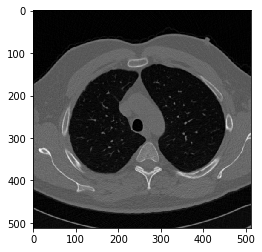

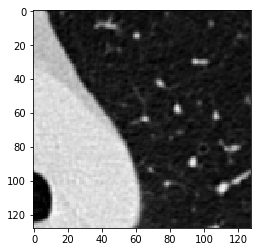

In [0]:
########################## Testing the ct_scan_processing class for different sub- image sizes #########################

scan = ct_scan_processing(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(2000)
plt.figure()
plt.imshow(image, cmap = 'gray')
image = scan.get_subimage(128)
plt.figure()
plt.imshow(image, cmap = 'gray')



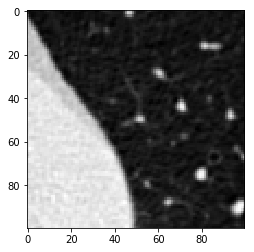

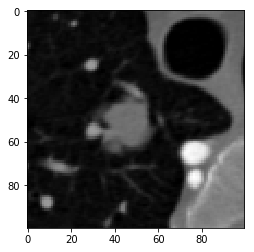

In [0]:
############################ Testing the ct_scan_processing class on images with and without tumors ############################

scan = ct_scan_processing(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(100)
plt.figure()
plt.imshow(image, cmap = 'gray')

scan = ct_scan_processing(np.asarray(candidates.iloc[positives[10]])[0], \
              np.asarray(candidates.iloc[positives[10]])[1:-1])
scan.read_mhd_image()
image = scan.get_subimage(100)
plt.figure()
plt.imshow(image, cmap = 'gray')

In [0]:
def create_data(idx, outDir, X_data,  width = 50):
    '''
    Aids in creating .jpg variant of original images
    '''
    mhd_image_path = "D:/zipped folder/**/"
    scan = ct_scan_processing(np.asarray(X_data.loc[idx])[0],np.asarray(X_data.loc[idx])[1:], mhd_image_path)
    outfile = outDir  +  str(idx)+ '.jpg'
    scan.save_image(outfile, width)

############################### Converting .mhd files to .jpg (cropped to recognize the nodules) ##############################

# X_train_data = pd.read_pickle('train_data')
# train_dir = 'D:/train_again/image_'
# Parallel(n_jobs = 12)(delayed(create_data)(i, train_dir, X_train_data) for i in X_train_data.index)

X_val_data = pd.read_pickle('eval_data')
validation_dir = 'D:/val_again/image_'
Parallel(n_jobs = 8)(delayed(create_data)(i, validation_dir, X_val_data) for i in X_val_data.index)

In [0]:
############################################### Data Augmentation using scipy ###############################################

def data_augmentation_module(idx, mode):
    '''
    Performs an angular transfirmation of images to yield data for augmentation. This helps us compensates for lack of
    sufficient positive cases in the data.
    '''
    input_image = imread('D:/'+ mode +'/image_' + str(idx)+ '.jpg')
#     plt.figure()
#     plt.imshow(input_image, cmap = 'gray')
    # Rotate by 90 and saving it in the train folder with new index
    input_to_90 = rotate(input_image, 90, reshape = False)
    Image.fromarray(input_to_90).convert('L').save('D:/val_again/' +'image_' + str(idx+1000000) + '.jpg')
    # Rotate by 180 and saving it in the train folder with new index
    input_to_180 = rotate(input_image, 180, reshape = False)
    Image.fromarray(input_to_180).convert('L').save('D:/val_again/' + 'image_' + str(idx+2000000) + '.jpg')

X_train = pd.read_pickle('eval_data')
mode = 'val_again'
y_train = pd.read_pickle('eval_labels')
indices = X_train[y_train == 1].index
Parallel(n_jobs = 8)(delayed(data_augmentation_module)(i, mode) for i in indices)

In [0]:
###################################### Building HD5 dataset with tensorflow ######################################

def pickle_to_hdf5_file(mode):
    '''
    Creates an HDF5 for tensorflow operations using the indices in the pickle file
    for train, validation,test.
    '''    
    X = pd.read_pickle('train' + '_data')
    y = pd.read_pickle('train' + '_labels')  
    index_list = X.index.to_series()    
    files = index_list.apply(lambda x:'D:/'+ mode+ '/image_'+str(x)+'.jpg')
    # Add augmented images to files
    pos_indices = []
    for i in y[y==1].index:
        pos_indices.append([i+1000000])
    index = [i+1000000 for i in y[y==1].index]
    pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
    files_aug_1 = pos_indices.apply(lambda x:'D:/'+ mode+ '/image_'+str(x)+'.jpg')
    files_aug_1
    pos_indices = []
    for i in y[y==1].index:
        pos_indices.append([i+2000000])
    index = [i+2000000 for i in y[y==1].index]
    pos_indices = pd.Series( (v[0] for v in pos_indices), index = index)
    files_aug_2 = pos_indices.apply(lambda x:'D:/'+ mode+ '/image_'+str(x)+'.jpg')
    files = files.append(files_aug_1)
    files = files.append(files_aug_2)
    # Adding labels for augmented images to y
    pos_idx = [i+1000000 for i in y[y==1].index]
    labels_aug_1 = [[1] for i in range(len(y[y==1].index))]
    y_1 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
    pos_idx = [i+2000000 for i in y[y==1].index]
    labels_aug_2 = [[1] for i in range(len(y[y==1].index))]
    y_2 = pd.Series( (v[0] for v in labels_aug_1), index = pos_idx)
    y = y.append(y_1)
    y = y.append(y_2)
    # Convert files and labels to arrays
    files = files.values.astype(str)
    labels = y.values.astype(int)
    # Arrays -> Dataset
    dataset = pd.DataFrame({'files':files,'labels':labels})
    # Dataset -> Interim Storage in a text file
    dataset_file = mode + '_data_labels.txt'
    np.savetxt(dataset_file, dataset, fmt="%10s %d")
    # Text File -> HDF5 images dataset
    hdf5_file_name = mode + 'dataset.h5'
    build_hdf5_image_dataset(dataset_file, image_shape = (50, 50, 1),mode ='file', output_path = hdf5_file_name, 
    categorical_labels = True, normalize = True, grayscale = True)

In [0]:
# modes = ['train_again', 'val_again', 'test']
# # Train HDF5
# pickle_to_hdf5_file(modes[0])
# # Validation HDF5
# # pickle_to_hdf5_file(modes[1])
# # # Test HDF5
# # pickle_to_hdf5_file(modes[2])

In [0]:
################################################## Loading HDF5 dataset ######################################################

# Load HDF5 dataset
def load_hdf_dataset(mode):
    h5_file = h5py.File(mode+ 'dataset.h5', 'r')
    images = h5_file ['X']
    labels = h5_file ['Y'][:]
    
    images = images[:,:,:].reshape([-1,50,50,1])
    h5_file.close()
    return images, labels 




train_images , labels = load_hdf_dataset('train_again')

print(train_images[0])

val_images , val_labels = load_hdf_dataset('val_again')



In [0]:
def build_squeezenet(input_shape):
    
    input_layer = Input(shape = input_shape)
    
    out = Conv2D(96, kernel_size =(3, 3), activation='relu')(input_layer)
    out = MaxPooling2D(pool_size=2, strides=None, padding='valid')(out)
    # no mxpooling done since small images 
    out = fire_module(out,squeeze =16 , expansion =64)
    out = fire_module(out,squeeze = 16 , expansion=64)
    
    out = fire_module(out,squeeze= 32,expansion = 128)
    out = fire_module(out,squeeze= 32,expansion = 128)
    
    out = fire_module(out , squeeze = 48 ,expansion=192)
    out = fire_module(out,squeeze = 48 , expansion = 192)
    
    out = fire_module(out,squeeze = 64 , expansion = 256)
    out = fire_module(out,squeeze = 64 , expansion = 256)
    
    out = Dropout(0.5)(out)
    
    out = Conv2D(2,kernel_size=(1,1),padding='valid',activation='tanh')(out)
    
    out = GlobalAveragePooling2D()(out)
    out = Dense(2, activation="sigmoid")(out)
       
    model = Model(input_layer, out, name='squeezenet')
    return model  

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [0]:
def fire_module(input_layer, squeeze =16 , expansion =32):

# a definition for fire module et.al https://github.com/rcmalli/keras-squeezenet/
# inspiration out = tf.map_fn(lambda x: threshold_binarize(x, threshold=0.5) , out, dtype=tf.int64)
# squeezing using 1x1 kernel and expansion with 1x1 and 3x3. Concatenate the output to get best result.

    fire_sq = Conv2D(squeeze,1,1,activation='relu')(input_layer)
    fire_exp1 = Conv2D(expansion ,kernel_size=(1,1),activation='tanh',padding='valid')(fire_sq)
    fire_exp2 = Conv2D(expansion ,kernel_size=(3,3),activation='tanh',padding='same')(fire_sq)
    out = concatenate([fire_exp1,fire_exp2], axis=3)

    return out

In [0]:
# model_dw = build_squeezenet(input_shape= (50,50,1))

# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# model_dw.compile(
#     optimizer=sgd, loss='binary_crossentropy',
#     metrics=['accuracy'])
# model_dw.summary()
# model_dw.fit(x=train_images, 
#             y=labels, 
#             batch_size=64,
#             epochs=10, 
#             verbose=1,  
# #             validation_split=0.2,
#             validation_data=(val_images,val_labels), 
#             shuffle=True)

# pred = model_dw.predict(val_images)


In [0]:
pred[pred<=0.5]

array([0.42874116, 0.42874068, 0.42874312, ..., 0.42874175, 0.42873842,
       0.4287405 ], dtype=float32)

In [0]:
model_dw.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 48, 48, 96)   960         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 48, 48, 16)   1552        conv2d_131[0][0]                 
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 48, 48, 64)   1088        conv2d_132[0][0]                 
__________________________________________________________________________________________________
conv2d_134

,0
0,D:/train_again/image_247896.jpg 0
1,D:/train_again/image_410153.jpg 0
2,D:/train_again/image_8941.jpg 0
3,D:/train_again/image_2826.jpg 0
4,D:/train_again/image_219239.jpg 0
5,D:/train_again/image_436163.jpg 1
6,D:/train_again/image_14141.jpg 1
7,D:/train_again/image_457933.jpg 1
8,D:/train_again/image_340200.jpg 0
9,D:/train_again/image_198850.jpg 0
